# Web Intelligence - Laboratory I

This notebook contains the twitter export and analysis code for Laboratory I of the Web Intelligence course held at Universitat Pompeu Fabra- Barcelona.

We have provided the output of some of our work (focusing on mentions of "Venezuela"), please scroll down to see this. There you will find a print out of 10 seconds of tweets mentioning this topic in all languages. A number of graphs assessing the sentiment of the tweets, and a wordcloud showing the words used in the tweets.

______________________________________________________________________________________________________________________________

In order to run the code please scroll down until you find the "Run Code Here" section. 

Note: In order to run the code you will need to input your Twitter Developer Keys.

Note: By running the code it will erase the previous analysis from the screen!

By default the the twitter stream listener will run for 5 seconds, with "Venezuela" as the topic of interest. It will print all tweets to the screen along with the output of the sentiment, it will then provide analysis on the tweets and finally produce a wordcloud.

______________________________________________________________________________________________________________________________

Note: To make the wordcloud you need to have installed the "wordcloud" library --> pip install wordcloud

Note: to make the wordcloud into the shape of a twitter bird you need to have save the "twitter_logo.jpg" (which is included in the submitted package) in the same location as this notebook.
        
Note: In order to use the fullspanish stopword dictionary you need to have "stopwords_spanish.csv" (which is included in the submitted package) in the same directory as this notebook, without this there will only be limited abililty to produe wordclouds from spanish tweets.
        
______________________________________________________________________________________________________________________________

Team members:

Alex G

+ two other team members
+ some initil code from the lecturer

## Import Libraries

In [1]:
print("Importing libraries...")
# !pip install wordcloud # Install wordcloud library in case you don't have it
from tweepy import OAuthHandler
import tweepy 
import simplejson as json
from textblob import TextBlob
from tweepy import Stream
from tweepy.streaming import StreamListener
from pprint import pprint
import pandas as pd
import json
import time

import numpy as np
import pandas as pd

from os import path
import sys
from PIL import Image
try:
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    wordCloudImportSuccessful = True
except ImportError:
    wordCloudImportSuccessful = False
    print("In order to generate wordclouds you need")
    print("To import the 'worldcloud' library")

try:
    spanishStopwordsDF = pd.read_csv("stopwords_spanish.csv", header = None)

    span = set(spanishStopwordsDF[0])

    stopWordsEngSpan = span.union(STOPWORDS)
    stopWordsEngSpan.update(["RT", "http", "https", "co","que","de","del"])
except:
    stopWordsEngSpan = set(STOPWORDS)
    stopWordsEngSpan.update(["RT", "http", "https", "co","que","de","del","para","la","lo","el"])
    


import matplotlib.pyplot as plt
print("Importing complete.")

%pylab inline
plt.rcParams["figure.figsize"] = (12, 9)

Importing libraries...
Importing complete.
Populating the interactive namespace from numpy and matplotlib


## Add keys and token below

In [56]:
# Keys

# Add Twitter Developer Kyes and Tokens here

consumerKey = ""
consumerSecret = ""
accessToken = ""
accessSecret = ""

if (consumerKey == "" or
    consumerSecret == "" or
    accessToken == "" or
    accessSecret == ""):
    print("Must provide access token to run code")
    sys.exit(0)


# OAuth

auth = OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessSecret)

# API

api = tweepy.API(auth)


## Retrieve own Twitter timeline

In [57]:
# Run if you would like to inspect the last nItems of your 
# own twitter timeline

nItems = 10
for status in tweepy.Cursor(api.home_timeline).items(nItems):
    print(status.text)
    print()
    print('_____')
    print()


output removed from github as it contains individual tweets

## Someone else's Twitter Analysis

The correlation between the two variables is:  [1.         0.79990437]


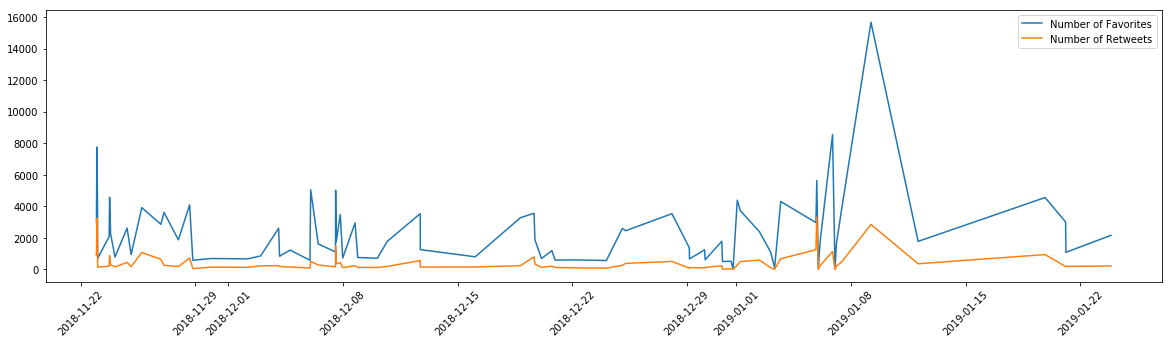

In [58]:
# Run if you would like to inspect the last nItems of  someone else's timeline (specific user)

userID = "nemoaponte"

nItems = 150

# All the tweets done by a user (chronologically)

tweets = api.user_timeline(screen_name = userID,
                           
                           # 200 is the maximum allowed count
                           
                           count = nItems,
                           
                           include_rts = False,
                           
                           # Otherwise only the first 140 words are extracted
                           
                           tweet_mode = 'extended')

ID = []
favourites = []
retweets = []
createdAt = []
fulltext = []

# Searching specific information in our timeline

for info in tweets:
    ID.append(info.id)
    favourites.append(info.favorite_count)
    retweets.append(info.retweet_count)
    createdAt.append(info.created_at)
    fulltext.append(info.full_text)

# Used to control the size of the graph

plt.figure(figsize = (20, 5))
plt.plot(createdAt, favourites, label = 'Number of Favorites')
plt.plot(createdAt, retweets, label = 'Number of Retweets')
plt.tick_params(axis = 'x', rotation = 45)
plt.legend()

print("The correlation between the two variables is: ", np.corrcoef(favourites, retweets)[0])

### Retrieve most favorite and retweeted twits 

In [59]:
# Searching the tweet with more favorites

elementToStudy_favourites = pd.Series(favourites).idxmax()

# Searching the tweet with more retweets

elementToStudy_retweets = pd.Series(retweets).idxmax()

# If one tweet has both max number of favorites and retweets, only one line shows the info

if elementToStudy_favourites == elementToStudy_retweets: 
    tweet = api.get_status(ID[elementToStudy_favourites])
    print(tweet.text)
else: 
    tweet = api.get_status(ID[elementToStudy_favourites])
    print(tweet.text)
    
    tweet = api.get_status(ID[elementToStudy_retweets])
    print(tweet.text)


removed form Github

## MyListener Function

In [60]:
# Listener class

class MyListener(StreamListener):
    
    def __init__(self,
                 topic,
                 locations = None,
                 languages = None,
                 timeLimit = 31536000, 
                 api = None, 
                 fileName = None, 
                 tweetLimit = 10000000,
                 printToScreen = True,
                 plotSentimentFlag = True):
        
        super(StreamListener, self).__init__()
        self.num_tweets = 0
        self.topic = topic
        self.locations = locations
        self.languages = languages
        self.startTime = time.time()
        
        # Time limit by default is 1 year
        
        self.timeLimit = timeLimit
        self.fileName = fileName
        self.tweetList = []
        self.tweetLimit = tweetLimit
        self.printToScreen = printToScreen
        self.plotSentimentFlag = plotSentimentFlag
        
    def PlotSentiment(self):
        polarityToPlot = []
        subjectivityToPlot = []
        xToPlot = []
        count = 0
        
        for item in self.tweetList:
            xToPlot.append(count)
            count += 1
        
            polarityToPlot.append(item[1][0])
            subjectivityToPlot.append(item[1][1])     
        
        plt.plot(xToPlot, polarityToPlot, label = 'Polarity')
        plt.plot(xToPlot, subjectivityToPlot, label = 'Subjectivity')
        plt.legend()
        plt.show()
        
        plt.scatter(polarityToPlot, subjectivityToPlot, c = polarityToPlot, s = 100, cmap = 'RdYlGn')
        plt.xlabel('Tweet polarity')
        plt.ylabel('Tweet subjectivity')
        plt.xlim(-1.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.show()
        
        positive_polarity = [p for p in polarityToPlot if p > 0]
        negative_polarity = [n for n in polarityToPlot if n < 0]
        neutral_polarity = [r for r in polarityToPlot if r == 0]
        
        total_size = len(positive_polarity) + len(negative_polarity) + len(neutral_polarity)
        n_size = len(negative_polarity) / total_size
        p_size = len(positive_polarity) / total_size
        r_size = len(neutral_polarity) / total_size

        labels = ['Neutral tweets', 'Positive tweets', 'Negative tweets']
        sizes = [r_size, p_size, n_size]
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels = labels, autopct='%1.1f%%',
        shadow = True, startangle = 90)
        ax1.axis('equal')
        plt.show()
        
        print("The polarity mean is: %.3f" %np.mean(polarityToPlot))
        print("The subjetivity mean is: %.3f" %np.mean(subjectivityToPlot))
        
    def SaveTweets(self):
        
        try:
            # Create file just with tweet text
            
            with open(self.topic + ".json" , 'a',encoding = 'utf-8')as f:
                for thisTweet in self.tweetList:
                    
                    f.write(json.loads(thisTweet[0])['text'])
                    
                    # Used to delimit the tweets
                    
                    f.write("\n-----\n")
            
            # Create a file with full tweet data and sentiment
            
            with open(self.topic + "_with_sentiment.json" , 'a',encoding = 'utf-8') as f:
                for thisTweet in self.tweetList:
                    f.write(str(thisTweet[1]).replace("\n","") + ", " + str(thisTweet[0].replace("\n","")))

        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
        
    def PrintTweets(self, twitterText, analysis):
        
        # This function prints tweets to the screen
        
        print(twitterText)
        print(" ")
        print("sentiment = ", analysis.sentiment)
        print("-----")
        
        
    def on_data(self, data):
        
        # Executes when data is recieved
        
        # If we have not reached the time limit or tweet limit then keep going
        
        if ((time.time() - self.startTime) < self.timeLimit) or (len(self.tweetList) + 1 > self.tweetLimit):

            # Assumes there is one tweet at a time
            # for some reason sometimes 'text' is not in the tweet... so this
            # stops any errors
            
            try:
                twitterText = json.loads(data)['text']
                analysis = TextBlob(twitterText)

                self.tweetList.append((data,analysis.sentiment))

                if self.printToScreen:
                    self.PrintTweets(twitterText, analysis)
            except KeyError:
                pass
        else:
            
            # If we have reached the time limit or tweet limit then stop listening 
            # and save the data
            
            print("SAVING")
            self.SaveTweets()
            
            # Print sentiment if requested (true by default)
            
            if self.plotSentimentFlag:
                self.PlotSentiment()
                
            return False
    
    def on_error(self, status):
        
        print('Error: ', status)
        
        return False


## CreateWordCloud Function

In [2]:
def CreateWordCloud(jsonFile, _stopwords = stopWordsEngSpan):
    
    # This function generates a wordcloud given an input file and stop words
    
    # Input:
    # jsonFile - string, file name or topic (which a file name has just been created from)
    
    # Inform the user that sometimes it takes awhile to produce a wordcloud
    # so they don't think there is a problem
    
    print("Generating word cloud (sometimes this takes a while)...")
    
    if not '.json' in jsonFile:
        
        # Then it is just a topic name so need to add the file 
        # extension to find the file which has just been created
        
        jsonFile = jsonFile + ".json"
        
    # Demiliting didn't work so tweets with new line chars will be spread across multiple lines
    # for this use case this is not a problem as we will combine all tweets into one long
    # string anyway
    
    tweetDF = pd.read_csv(jsonFile, engine = 'python',header = None, sep = "\n-----\n")
    
    # Remove the tweet separaters
    
    boolMask = tweetDF != "-----"
    temp_clean = tweetDF[boolMask]
    temp_clean.dropna(inplace = True)
    
    # Combine all text into a string for analysis
    
    text = " ".join(review for review in temp_clean[0])
        
    # Generate a wordcloud image
    
    try:
        
        # Try and do it in the shape of the twitter bird
        
        mask = np.array(Image.open("twitter_logo.jpg"))
        wordcloud_por = WordCloud(stopwords = _stopwords, background_color = "white", max_words = 1000, mask = mask).generate(text)
        
        # Create coloring from image
        
        image_colors = ImageColorGenerator(mask)
        plt.figure(figsize = [27,7])
        plt.imshow(wordcloud_por.recolor(color_func = image_colors), interpolation = "bilinear")
        plt.axis("off")
        
    except:
        
        # If you dont have the twitter bird logo then do it in the default way
        
        wordcloud_por = WordCloud(stopwords = _stopwords, background_color = "white", max_words = 1000).generate(text)
        plt.figure(figsize = [27,7])
        plt.imshow(wordcloud_por, interpolation = "bilinear")
        plt.axis("off")

## Main Function

In [62]:
def Main(_auth,
         _listener,
         _topic = 'Venezuela',
         _location = None,
         _language = None,
         _timeLimit = 31536000, 
         _tweetLimit = 10000000,
         _stopwords = stopWordsEngSpan,
         _printToScreen = True,
         _plotSentimentFlag = True,
         _drawWordCloud = wordCloudImportSuccessful):
    
    # This function contols the running of the project, it takes in a list of topics 
    # or can be an individual topic and a number of previous tweets to analyze, and provides the
    # tweets and sentiment analysis to a file in json, and also prints out graphs to analyze
    # tweets through time.
    
    # Inputs
    
    # interestingTopicList - list of strings or string - 
    
    # Location needs to be a lat- long bounding box if it is used
    # since this is not trivial we have included a couple of examples
    # to check it works
    
    if _location == "San Fransisco":
        _location = [-122.75,36.8,-121.75,37.8]
    elif _location == "New York City":
        _location = [-74.1687,40.5722,-73.8062,40.9467]
    
    # Create listener
    
    myListenerObj = _listener(topic = _topic,
                               timeLimit = _timeLimit,
                               tweetLimit = _tweetLimit,
                               printToScreen = _printToScreen,
                               plotSentimentFlag = _plotSentimentFlag)
    
    # Run listener
    
    twitter_stream = Stream(_auth, myListenerObj)
    twitter_stream.filter(track = [_topic], languages = _language, locations = _location)
    
    # If you have the wordcloud library installed, produce a wordcloud
    
    if _drawWordCloud:
        CreateWordCloud(_topic, _stopwords = _stopwords)

## Run Code Here

In order to run the analysis code please run the below cell.

Output removed for Github

Output removed for Github
sentiment =  Sentiment(polarity=0.0, subjectivity=0.0)
-----


output removed for Github

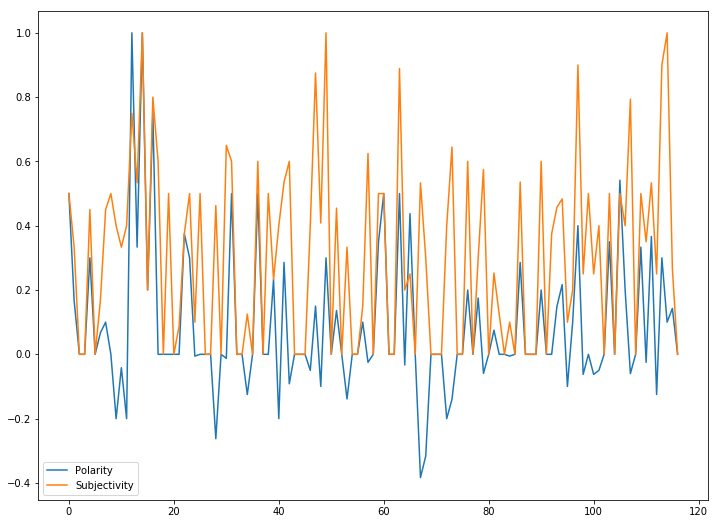

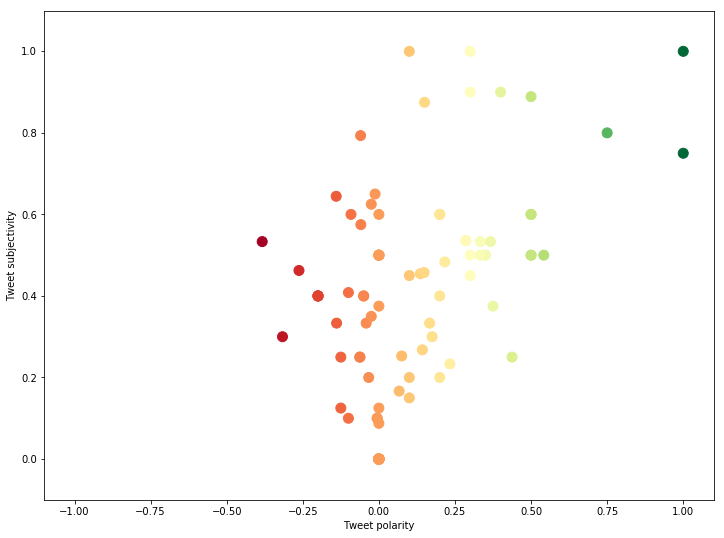

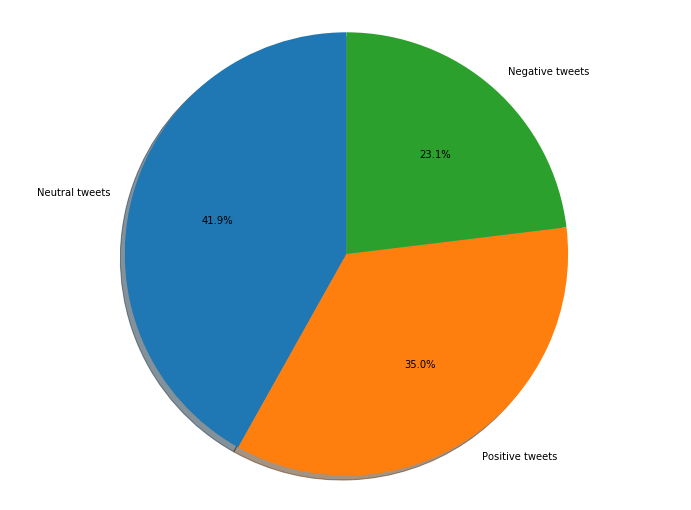

The polarity mean is: 0.087
The subjetivity mean is: 0.305
Generating word cloud (sometimes this takes a while)...


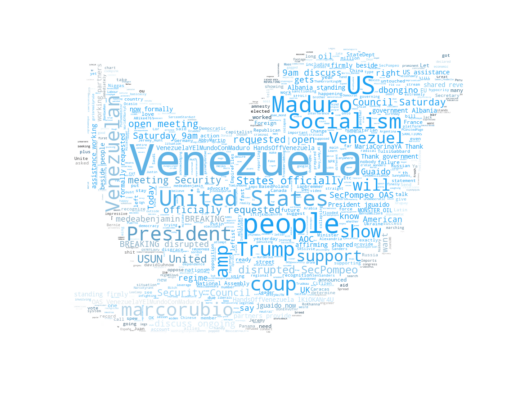

In [63]:
# Run the main code

Main(_auth = auth, _location = "New York City", _language = ["en"], _listener = MyListener, _timeLimit = 10)

Generating word cloud (sometimes this takes a while)...


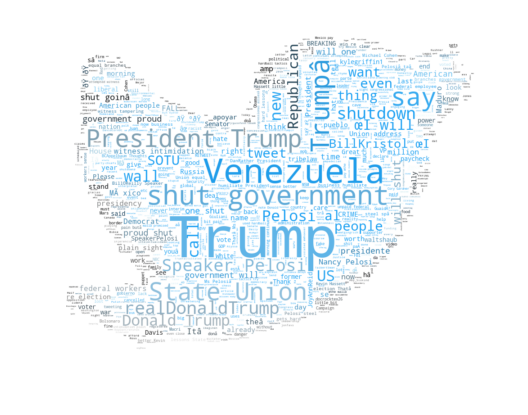

In [3]:
CreateWordCloud("trump")